# Semantic Dictiornary
- This notebook create semantic dictionaries for different midel inputs
- It also shows the atcivation plots

In [2]:
import numpy as np
import tensorflow as tf


from sklearn.preprocessing import normalize
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image
import math
import requests
from io import BytesIO


import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte

In [3]:
from lucid.modelzoo.vision_base import Model

class DLA(Model):
    model_path = 'https://storage.googleapis.com/dla_protobuff/full_model_8_13.pb'
    image_shape = [1, 400]
    image_value_range = [0, 1]
    input_name = 'x'

In [4]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 50 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=267
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{210}}px; height: {{157}}px; background-position: -{{210*(act.n%sprite_n_wrap)}}px -{{157*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/denom}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 2048px;
    }
    .input_image {
        display: inline-block;
        width: 400px;
        height: 267px;
    }
    .input_image .image, .input_image .pointer_container {
        position: absolute;
        width: 400px;
        height: 267px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: .1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0],
        denom: 150
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[0]][0],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_mlc3vnuu/SemanticDict_74fc1050_9669_4f41_bc24_9fc7e6eb5292.html > /tmp/svelte_mlc3vnuu/SemanticDict_74fc1050_9669_4f41_bc24_9fc7e6eb5292.js
b'svelte version 1.64.1\ncompiling ../../../../../../tmp/svelte_mlc3vnuu/SemanticDict_74fc1050_9669_4f41_bc24_9fc7e6eb5292.html...\n'



In [5]:
LAYERS = { 'conv1': 'Conv2D',
           'conv1_relu':'Relu',
           'pool1': 'MaxPool',
           'conv2': 'Conv2D_1',
           'conv2_relu': 'Relu_1',
           'pool2': 'MaxPool_1',
           'conv3': 'Conv2D_2',
           'conv3_relu': 'Relu_2',
           'pool3': 'MaxPool_2',
         }


layer_spritemap_sizes = {
    'conv1': 10,
    'conv1_relu': 10, 
    'pool1': 10,
    'conv2': 12,
    'conv2_relu': 12,
    'pool2': 12,
    'conv3': 12,
    'conv3_relu': 12,
    'pool3': 12}


def dla_spritemap(layer):
    assert layer in layer_spritemap_sizes
    size = layer_spritemap_sizes[layer]
    url = "https://storage.googleapis.com/dla_spritemaps/1d_spritemaps/"+layer+"/"+layer+".png"
    return size, url

In [8]:
model = DLA()
model.load_graphdef()


def dla_semantic_dict(layer, test_input, img_file, hide=False):
    model_layer = LAYERS[layer]
    
    input_1d = test_input # Actual 1-Dimensional test input
#     print(input_1d)
    img = load(img_file)
    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session() as sess:
        t_input = tf.placeholder(tf.float32, shape=[1, 400, 1, 1])
        T = render.import_model(model, t_input, t_input)
        acts = T(model_layer).eval(feed_dict={t_input: input_1d, 'import/keep_prob:0': .98})[0]
        
    
    # Find best position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = dla_spritemap(layer)
    
    if hide == False:
      # Display the interactive display by calling the svelte component
      # Actually construct the semantic dictionary interface
      # using our *custom component*
      lucid_svelte.SemanticDict({
          "spritemap_url": spritemap_url,
          "sprite_size": 210,
          "sprite_n_wrap": spritemap_n,
          "image_url": _image_url(img),
          "activations": [[[{"n": float(n), "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
          "pos" : [float(max_x), 0],
          "denom": 150
          
      })
      
    return acts

In [11]:
def resize_input(image_file):
    # Reszies the data input to have length of 400
    img = Image.open(image_file)
    img = img.resize((400,267), Image.ANTIALIAS)
    img.save(image_file)
    
def run(data, start, layer, hide=False):
    # Loads data, and looks at only 400 length segment, specified by start + 400
    flux = np.load(data)
    flux_test = flux[start:start+400]
    flux_test = flux_test.reshape(1, 400, 1, 1)
    
    # Plot spectra data
    flux_graph = flux_test.reshape(400)
    fig = plt.figure(frameon=False);
    ax = plt.Axes(fig, [0, 0, 1, 1]);
    ax.set_axis_off();
    fig.add_axes(ax);
    ax.plot(flux_graph, 'black');
    ax.set(xlim=(0, 400));
    
    # Save file, will need to refertence later
    file_save = 'flux_' + str(start) + '.png'
    fig.savefig(file_save);
    plt.close(fig)
    resize_input(file_save)
    
    # Run the semantic dict and return the acts
    acts = dla_semantic_dict(layer, flux_test, file_save, hide)
    return acts


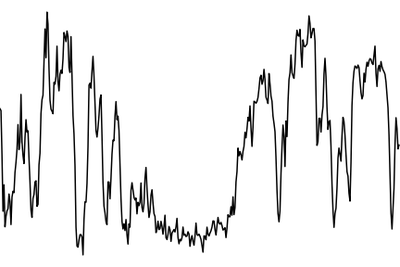

In [24]:
activations = run('../data/spectra/flux.npy', 0, 'conv2', False)

# Activation plots

In [14]:
def get_max_vals(activations):
    max_acts = []
    for a in activations:
        m = max(a[0])
        max_acts.append(m)
    return max_acts

def plot_acts(activations, title):
    max_acts = get_max_vals(activations)
    #plt.clf()
    fig = plt.figure(dpi=60)
    ax = fig.add_subplot(111)
    ax.plot(max_acts, 'k-')
#     ax.set_ylim(0, 150)
    plt.title(title)
    plt.ylabel('Activation Amount', fontsize=20.)
    plt.xlabel('Convolutional Channel', fontsize=20.)
    plt.show()
    plt.close()
    
def create_multiple_plots(data, start, layers):
    # Plot the data 
    flux = np.load(data)
    fig = plt.figure(dpi=60)
    ax = fig.add_subplot(111)
    ax.plot(flux[start:start+400], 'k-')
    plt.ylabel('Flux', fontsize=20.)
    plt.show()
    
    # plot activation maps
    for l in layers:
        tmp = run(data, start, l, True)
        plot_acts(tmp, l)

In [15]:
all_layers = ['conv1', 'conv1_relu', 'pool1',
              'conv2', 'conv2_relu', 'pool2',
              'conv3', 'conv3_relu', 'pool3']


# flux.npy activation plots

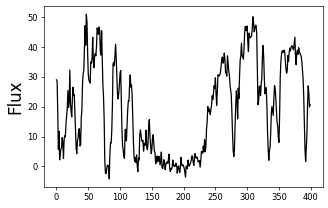

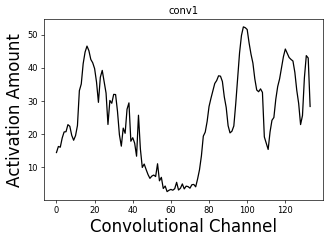

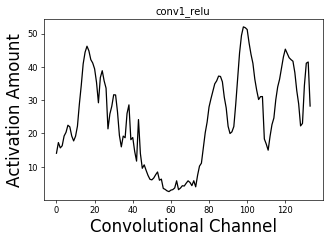

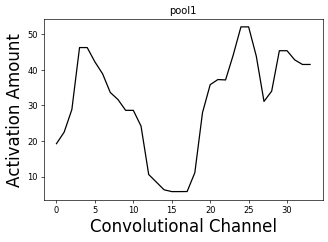

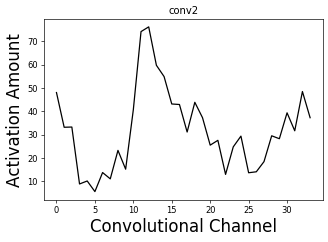

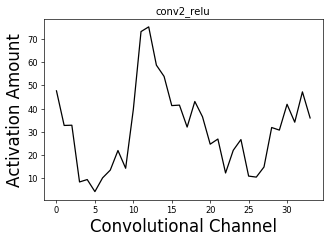

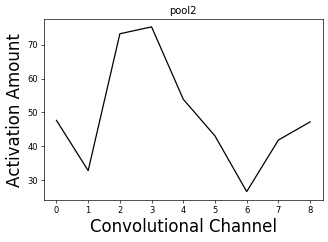

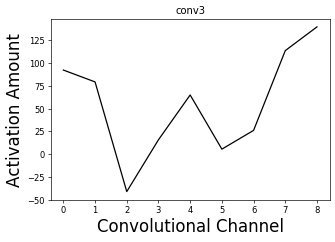

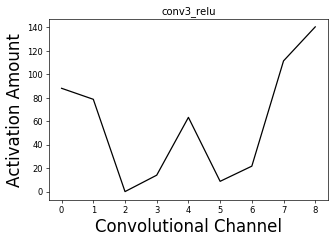

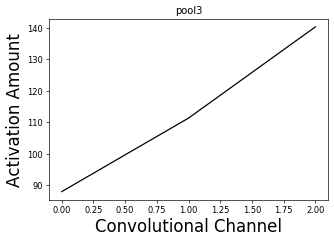

In [16]:
create_multiple_plots('../data/spectra/flux.npy', 0, all_layers)

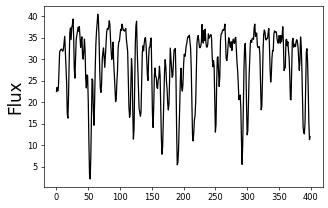

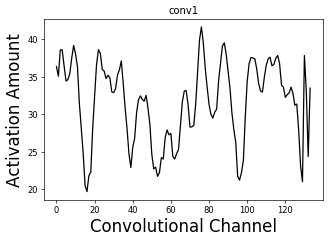

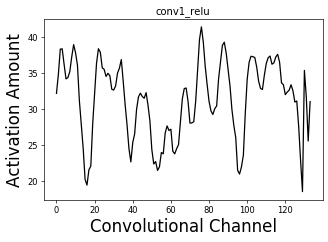

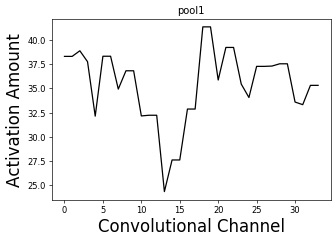

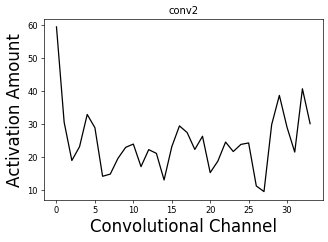

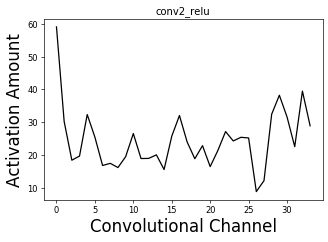

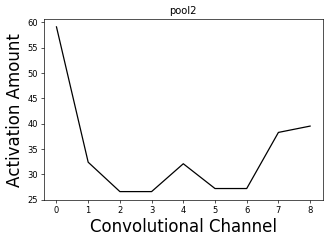

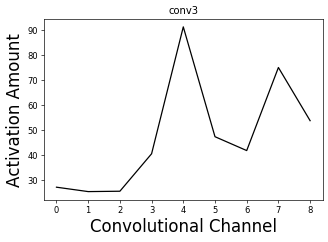

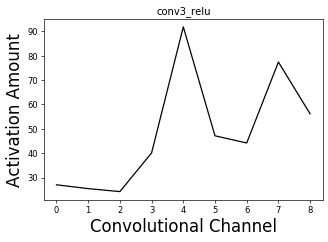

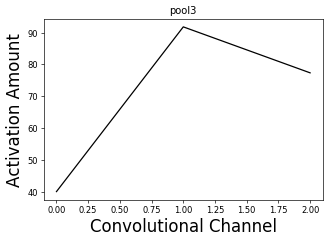

In [17]:
create_multiple_plots('../data/spectra/flux.npy', 400, all_layers)

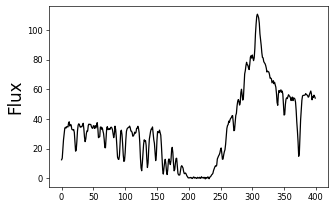

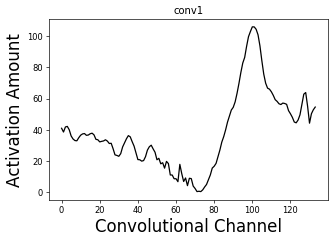

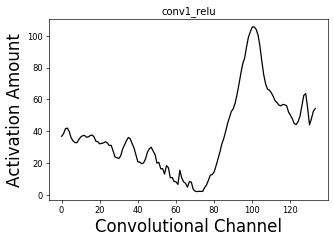

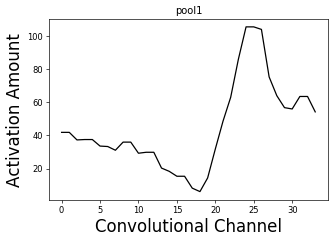

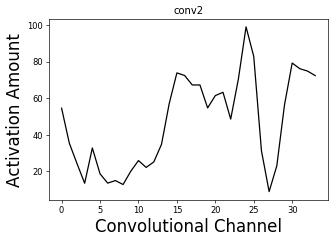

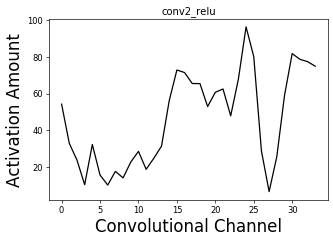

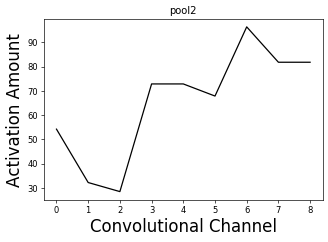

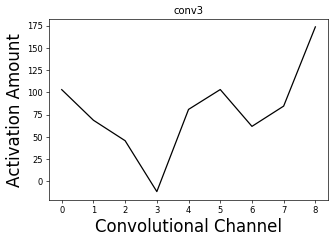

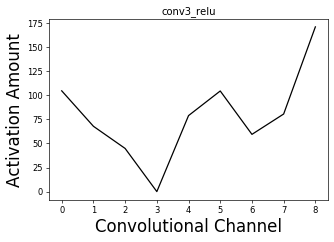

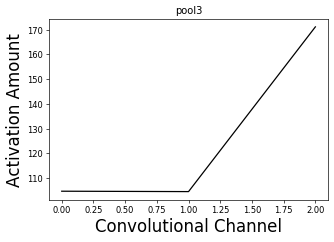

In [18]:
create_multiple_plots('../data/spectra/flux.npy', 700, all_layers)

# flux0.npy activation plots

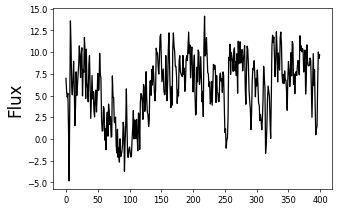

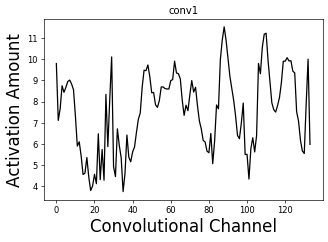

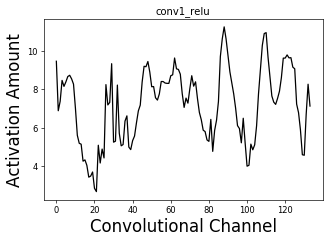

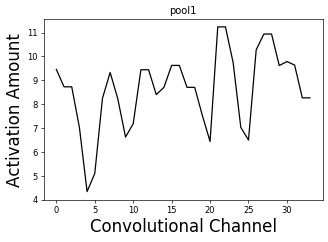

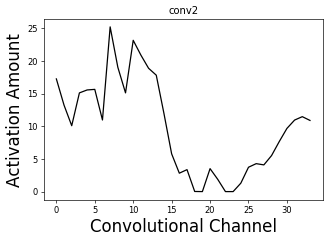

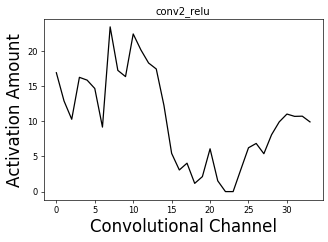

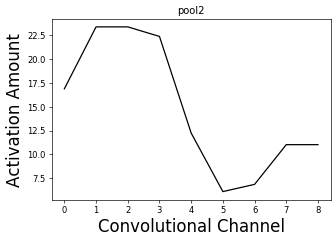

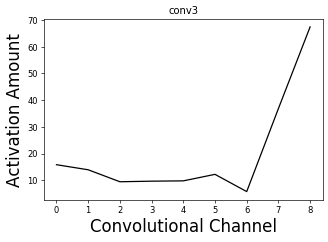

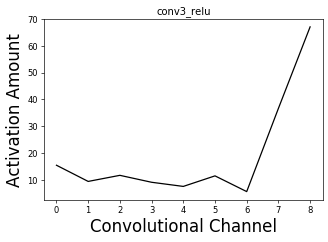

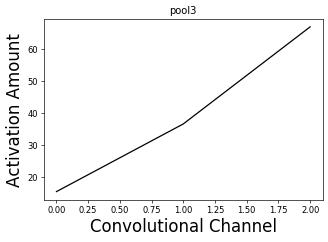

In [19]:
create_multiple_plots('../data/spectra/flux0.npy', 0, all_layers)

# flux1.npy activation plots

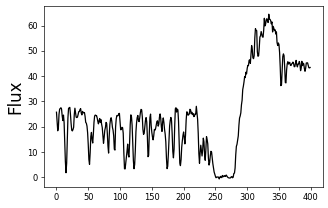

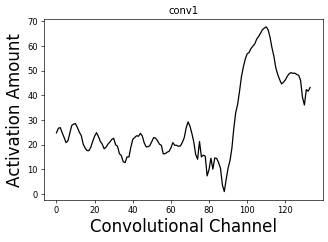

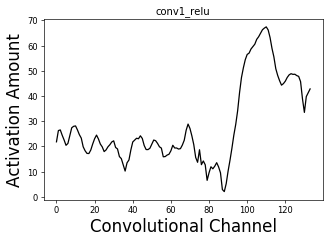

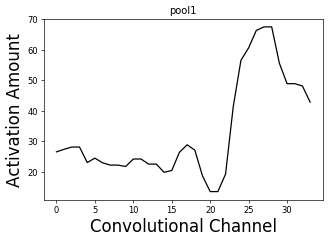

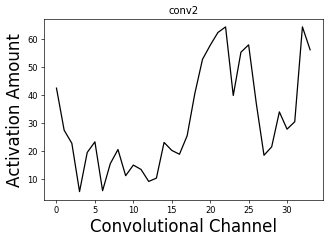

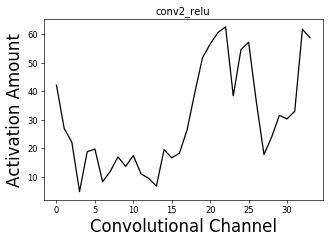

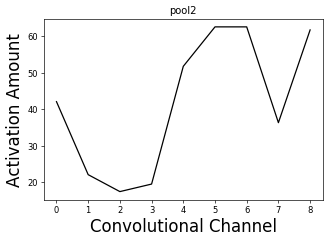

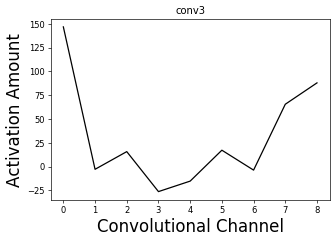

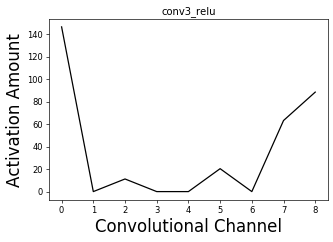

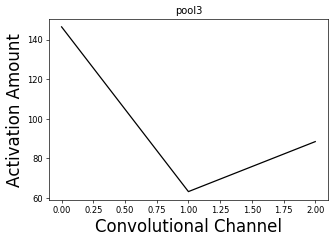

In [20]:
create_multiple_plots('../data/spectra/flux1.npy', 950, all_layers)

# flux2.npy activation plots

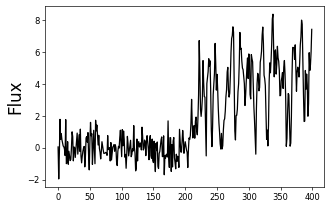

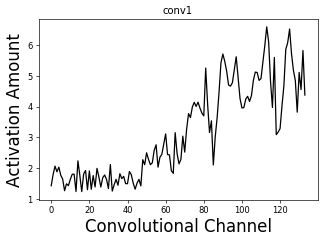

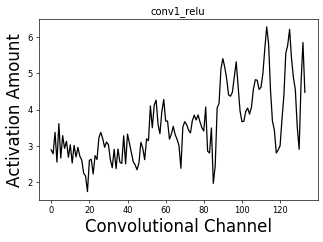

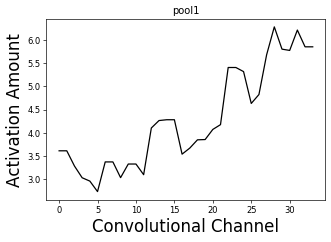

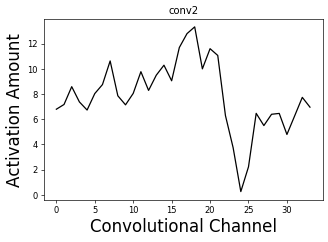

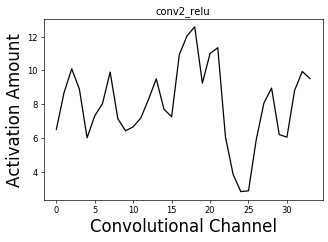

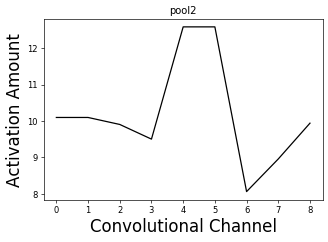

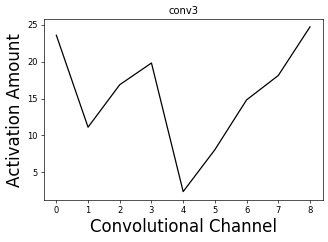

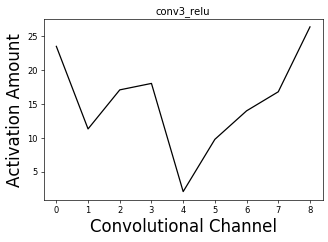

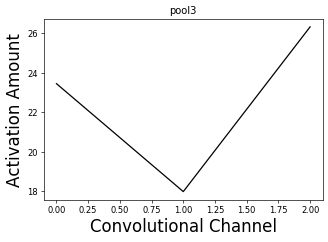

In [21]:
# small class output
create_multiple_plots('../data/spectra/flux2.npy', 600, all_layers)

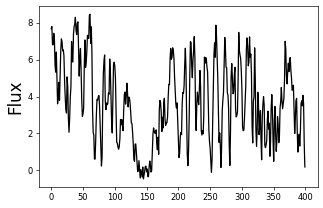

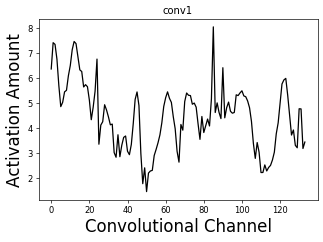

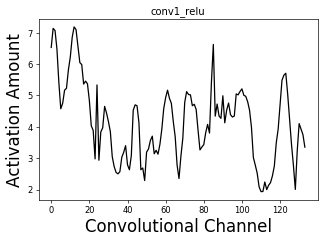

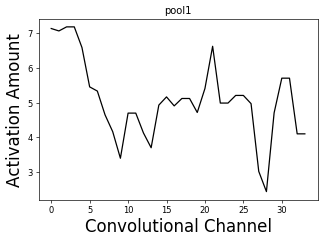

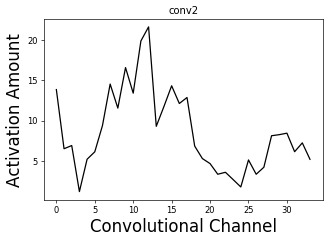

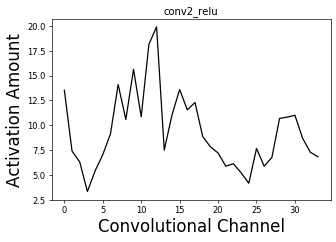

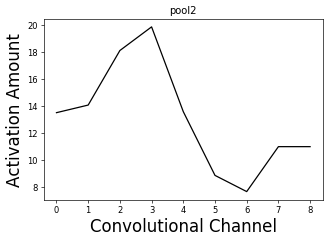

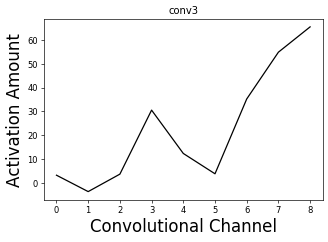

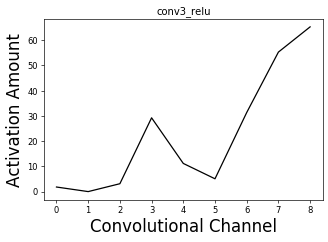

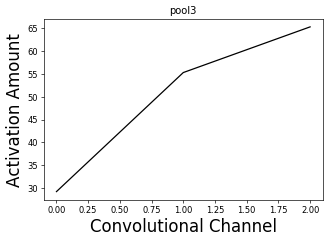

In [22]:
# small class output
create_multiple_plots('../data/spectra/flux2.npy', 1450, all_layers)

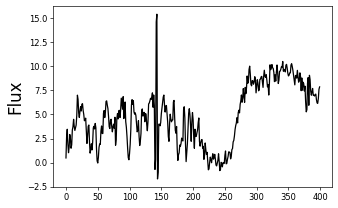

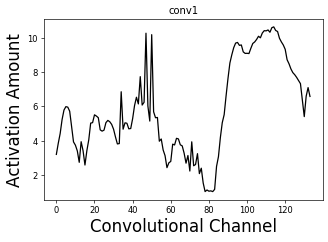

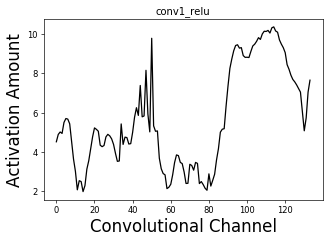

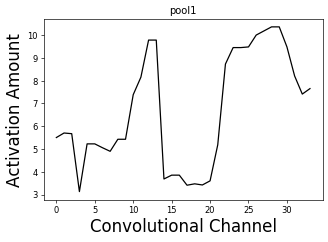

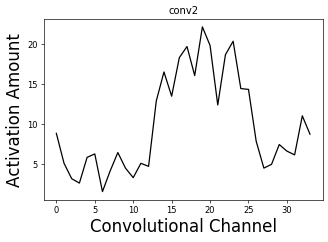

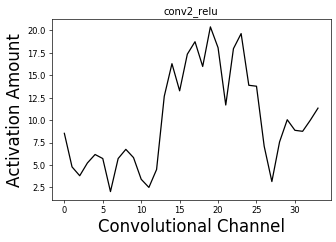

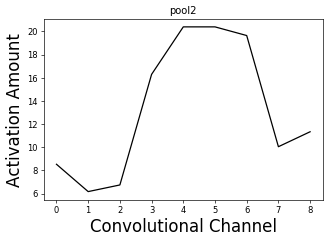

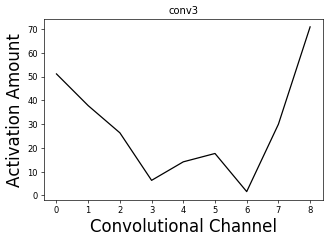

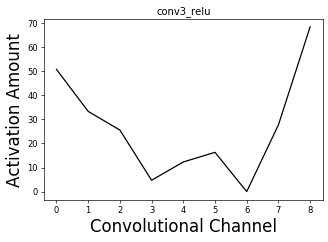

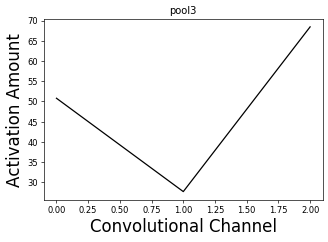

In [23]:
create_multiple_plots('../data/spectra/flux2.npy', 1800, all_layers)